## 概要
priorとlikelihoodに関する情報をコードしているニューロンの役割分担がどの程度行われているのかを定量化する。

あるニューロンの時間発展 $x(t)$ を考える。環境変化を $E(t)$ とする。

- likelihoodのcoding率: 同一のEにおける $x(t)$ の分散 $\langle x^2\rangle - \langle x\rangle^2 $の異なるEに関する平均
- priorのcoding率: 同一のEにおける$x(t)$の平均$[x(t)]$の異なるEに関する分散

In [1]:
import os
import math

import matplotlib
import numpy as np
import sys
import scipy
import yaml

from sklearn.metrics import mean_squared_error

sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from matplotlib import cm

from slow_reservoir.model import RNN, RNNSimple
from slow_reservoir.dataset.dynamic_state import State

%matplotlib inline

In [2]:
state_list = [
    State(mu=0, sigma=0.2),
    State(mu=-0.5, sigma=0.1),
    State(mu=0.5, sigma=0.4),
]

In [3]:
def make_signal(N, time_length, state_list, uncertainty=0.5):
    input_signals = np.zeros([N, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    sigma_sq = 0.5
    target_list = np.zeros([N, 400])
    signal_mu_list = np.zeros((N, time_length))
    true_signal_list = np.zeros((N, time_length))
    
    for i in range(N):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            true_signal = state_list[(t // 40) % 3]()
            true_signal_list[i, t] = true_signal
            # true_signal = state_list[2]()
            g = 1
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            signal_mu_list[i, t] = signal_mu
            
            signal_base = g * 1 * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        # signal_mu_list.append(signal_mu)
        
    return input_signals, true_signal_list, signal_mu_list

In [4]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220526_all_slow/20220526_all_slow.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()



model_name:  20220526_all_slow


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [5]:
sample_num = 1000
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=120, 
    uncertainty=0.5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))
             

# priorなしのモデルによる推論
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs, prior_list, reservoir_list = model(inputs, hidden, reservoir, 120)                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()


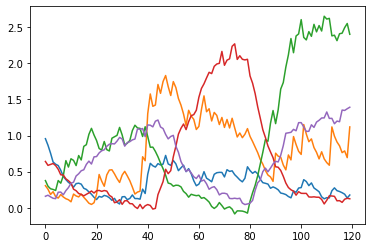

In [6]:
plt.plot(neural_dynamics[0, :, 1])
plt.plot(neural_dynamics[0, :, 8])
plt.plot(neural_dynamics[0, :, 13])
plt.plot(neural_dynamics[0, :, 14])
plt.plot(neural_dynamics[0, :, 16])

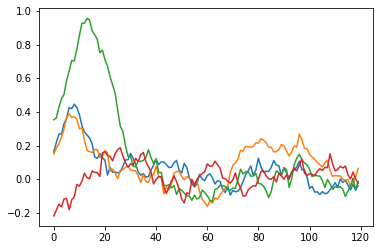

In [7]:
plt.plot(reservoir_dynamics[0, :, 9])
plt.plot(reservoir_dynamics[0, :, 13])
plt.plot(reservoir_dynamics[0, :, 4])
plt.plot(reservoir_dynamics[0, :, 26])

### Calculation

In [8]:
var_activity_list = []
mean_activity_list = []
for i in range(3):
    E_time_series = neural_dynamics[:, i*40:(i+1)*40, 6].reshape(1000*40)
    var_activity_list.append(np.var(E_time_series))
    mean_activity_list.append(np.mean(E_time_series))

In [9]:
np.mean(var_activity_list) / np.var(mean_activity_list)

1.3482404

In [10]:
var_activity_list = []
mean_activity_list = []
for i in range(3):
    E_time_series = neural_dynamics[:, i*40:(i+1)*40, 0].reshape(1000*40)
    var_activity_list.append(np.var(E_time_series))
    mean_activity_list.append(np.mean(E_time_series))
    
print(np.mean(var_activity_list) / np.var(mean_activity_list))

2.8566902


In [11]:
np.max(E_time_series)

2.910642

In [12]:
var_activity_list = []
mean_activity_list = []
for i in range(3):
    E_time_series = neural_dynamics[:, i*40:(i+1)*40, 13].reshape(1000*40)
    var_activity_list.append(np.var(E_time_series))
    mean_activity_list.append(np.mean(E_time_series))
    
print(np.mean(var_activity_list) / np.var(mean_activity_list))

0.89273316


In [13]:
var_activity_list = []
mean_activity_list = []
for i in range(3):
    E_time_series = neural_dynamics[:, i*40:(i+1)*40, 16].reshape(1000*40)
    var_activity_list.append(np.var(E_time_series))
    mean_activity_list.append(np.mean(E_time_series))
    
print(np.mean(var_activity_list) / np.var(mean_activity_list))

3.7733235


In [14]:
var_activity_list = []
mean_activity_list = []
for i in range(3):
    E_time_series = reservoir_dynamics[:, i*40:(i+1)*40, 1].reshape(1000*40)
    var_activity_list.append(np.var(E_time_series))
    mean_activity_list.append(np.mean(E_time_series))
    
print(np.mean(var_activity_list) / np.var(mean_activity_list))

4.347124


In [15]:
var_activity_list = []
mean_activity_list = []
for i in range(3):
    E_time_series = reservoir_dynamics[:, i*40:(i+1)*40, 0].reshape(1000*40)
    var_activity_list.append(np.var(E_time_series))
    mean_activity_list.append(np.mean(E_time_series))
    
print(np.mean(var_activity_list) / np.var(mean_activity_list))

16.67491


In [16]:
var_activity_list = []
mean_activity_list = []
for i in range(3):
    E_time_series = reservoir_dynamics[:, i*40:(i+1)*40, 3].reshape(1000*40)
    var_activity_list.append(np.var(E_time_series))
    mean_activity_list.append(np.mean(E_time_series))
    
print(np.mean(var_activity_list) / np.var(mean_activity_list))

1.7670934


In [17]:
np.max(neural_dynamics[:, :, 0])

2.910642

#### fast neuron側

In [18]:
coding_ratio_dict = {}
for i in range(cfg['MODEL']['SIZE']):
    if np.max(neural_dynamics[:, :, i]) < 1:
        continue
    var_activity_list = []
    mean_activity_list = []
    for j in range(3):
        E_time_series = neural_dynamics[:, j*40:(j+1)*40, i].reshape(1000*40)
        var_activity_list.append(np.var(E_time_series))
        mean_activity_list.append(np.mean(E_time_series))
       
    coding_ratio = np.mean(var_activity_list) / np.var(mean_activity_list)
    if coding_ratio >= 20:
        continue
    coding_ratio_dict[i] = np.mean(var_activity_list) / np.var(mean_activity_list)

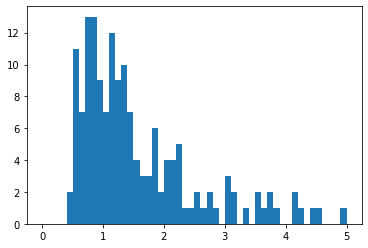

In [19]:
plt.hist(coding_ratio_dict.values(), bins=50, range=(0, 5))
plt.show()

#### sub-network側

In [20]:
reservoir_coding_ratio_dict = {}
for i in range(cfg['MODEL']['RESERVOIR']):
    if np.max(reservoir_dynamics[:, :, i]) < 1:
        continue
    var_activity_list = []
    mean_activity_list = []
    for j in range(3):
        E_time_series = reservoir_dynamics[:, j*40:(j+1)*40, i].reshape(1000*40)
        var_activity_list.append(np.var(E_time_series))
        mean_activity_list.append(np.mean(E_time_series))
       
    coding_ratio = np.mean(var_activity_list) / np.var(mean_activity_list)
    if coding_ratio >= 20:
        continue
    reservoir_coding_ratio_dict[i] = np.mean(var_activity_list) / np.var(mean_activity_list)

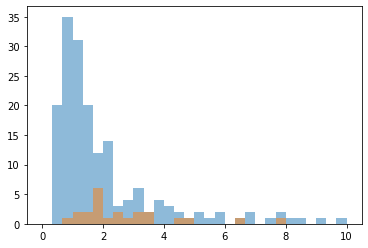

In [21]:
plt.hist(coding_ratio_dict.values(), bins=30, range=(0, 10), alpha=0.5)
plt.hist(reservoir_coding_ratio_dict.values(), bins=30, range=(0, 10), alpha=0.5)
plt.show()

In [22]:
coding_ratio_dict

{1: 4.2928405,
 3: 8.526045,
 6: 0.69106424,
 7: 5.2910566,
 8: 14.23274,
 9: 1.0824178,
 11: 17.650541,
 12: 1.155622,
 13: 1.5988965,
 14: 0.5024854,
 17: 17.312922,
 20: 9.242399,
 22: 12.055205,
 24: 10.193464,
 27: 1.9012685,
 29: 9.052277,
 33: 4.8918567,
 35: 11.908721,
 36: 1.393814,
 38: 11.101683,
 41: 7.8684487,
 42: 2.7718902,
 43: 3.4598227,
 45: 17.959152,
 46: 3.5439184,
 47: 13.084406,
 53: 0.69847107,
 54: 12.554624,
 55: 1.7063698,
 56: 11.535144,
 57: 16.322153,
 58: 3.2009318,
 59: 1.0508281,
 60: 3.7107692,
 61: 4.24001,
 62: 6.694975,
 64: 0.9216147,
 65: 16.09095,
 66: 6.0018673,
 67: 1.0660144,
 68: 1.7784584,
 78: 19.526175,
 80: 7.181175,
 82: 6.5769343,
 83: 10.273423,
 84: 2.580184,
 90: 16.300243,
 93: 4.2084084,
 100: 1.5597245,
 102: 3.3331008,
 103: 8.714066,
 113: 4.7265253,
 114: 17.490683,
 117: 1.8837807,
 118: 10.9117365,
 124: 19.977615,
 125: 2.9230978,
 126: 13.9849,
 128: 6.0262046,
 132: 19.076414,
 133: 3.4198332,
 134: 12.879975,
 140: 4.3131

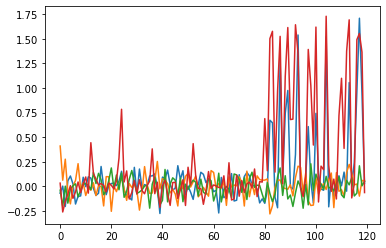

In [23]:
plt.plot(neural_dynamics[0, :, 3])
plt.plot(neural_dynamics[0, :, 40])
plt.plot(neural_dynamics[0, :, 167])
plt.plot(neural_dynamics[0, :, 193])

In [24]:
model.w_hh.weight

Parameter containing:
tensor([[-4.3201e-03, -2.9287e-05, -2.0873e-03,  ..., -1.6376e-03,
         -1.5304e-02, -3.8640e-03],
        [-1.4933e-02, -3.4977e-03, -5.8962e-04,  ..., -9.9088e-03,
         -6.2494e-02,  4.5850e-02],
        [-8.9586e-04, -1.4630e-03,  3.0419e-04,  ..., -7.3559e-04,
          7.8441e-04, -4.3011e-05],
        ...,
        [ 5.9419e-03,  8.1775e-03, -2.3925e-04,  ...,  2.1942e-02,
         -3.8797e-03, -5.3612e-03],
        [-2.7299e-02, -6.3823e-03, -7.1547e-04,  ..., -1.3000e-02,
          1.1387e-01, -1.0252e-02],
        [ 2.0813e-02,  1.2568e-02, -4.3940e-03,  ..., -8.9890e-03,
         -3.8464e-02,  1.3228e-02]], requires_grad=True)

In [25]:
np.sum(abs(model.w_in.weight.detach().numpy()[3, :]))

5.61876

In [26]:
np.sum(abs(model.w_in.weight.detach().numpy()[40, :]))

0.97835433

In [27]:
np.sum(abs(model.w_fs.weight.detach().numpy()[:, 3]))

1.164801

In [28]:
np.sum(abs(model.w_fs.weight.detach().numpy()[:, 40]))

0.30960312

In [29]:
np.sum(abs(model.w_fs.weight.detach().numpy()[:, 167]))

0.11384095

In [30]:
np.sum(abs(model.w_fs.weight.detach().numpy()[:, 193]))

1.1070763

In [31]:
np.sum(abs(model.w_sf.weight.detach().numpy()[3, :]))

1.5398659

In [32]:
np.sum(abs(model.w_sf.weight.detach().numpy()[40, :]))

0.52846926

In [33]:
np.sum(abs(model.w_sf.weight.detach().numpy()[167, :]))

0.23475303

In [34]:
np.sum(abs(model.w_sf.weight.detach().numpy()[193, :]))

1.5416259

In [35]:
np.sum(abs(model.w_hh.weight.detach().numpy()[:, 3]))

2.9233942

In [36]:
np.sum(abs(model.w_hh.weight.detach().numpy()[:, 40]))

1.2434645

In [37]:
np.sum(abs(model.w_hh.weight.detach().numpy()[:, 167]))

0.6391858

In [38]:
np.sum(abs(model.w_hh.weight.detach().numpy()[3, :]))

2.8994083

In [39]:
np.sum(abs(model.w_hh.weight.detach().numpy()[40, :]))

0.8881061

In [40]:
np.sum(abs(model.w_hh.weight.detach().numpy()[167, :]))

0.61474663

In [41]:
reservoir_coding_ratio_dict

{0: 1.2494994,
 1: 0.68368363,
 3: 3.393336,
 4: 1.0659238,
 5: 1.1005243,
 6: 0.8373588,
 8: 1.4902542,
 9: 2.557947,
 10: 1.0772679,
 11: 6.5191097,
 13: 7.812404,
 18: 2.6152945,
 19: 4.4604664,
 20: 1.5835531,
 22: 1.4292167,
 23: 1.159005,
 24: 2.1779335,
 25: 4.4161563,
 26: 4.251831,
 27: 3.0468066,
 28: 0.6850121,
 30: 7.184814,
 31: 1.9539349,
 33: 0.8629858,
 34: 0.9394849,
 35: 1.0442326,
 36: 0.84245145,
 38: 1.1904367,
 39: 3.0295284,
 40: 1.003211,
 41: 2.200551,
 42: 2.9866989,
 45: 0.6139795,
 49: 1.296445}

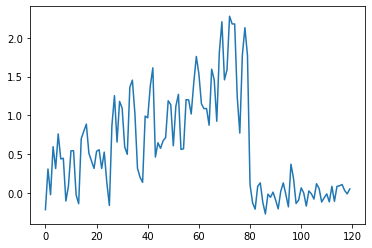

In [42]:
plt.plot(neural_dynamics[0, :, 6])